# GMM_Part1B

By Wanyan Shao, Zhaohe Huang, Xiao Han Xiong

In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
import numpy.random as npr
import random as pr
from scipy.stats import multivariate_normal, t
import scipy.cluster.vq as vq
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import mixture
import seaborn as sns

## (i) GMM Implementation from Scratch

In [2]:
class GMM:
    """
    Code GMM from scratch implementing the EM algorithm
    density estimation algorithm
    """
    def __init__(self, ncomps = None, method = None, tol = 0.1, nsteps = 100):
        """
        ncomps: number of clusters (additive components) in GMM
        method: initialization method
        tol: stopping criterion of log likelihood function. EM iterations will stop when the 
             lower bound average gain is below this threshold.
        nsteps: maximum steps of EM algorithm
        """
        self.tol = tol
        self.method = method
        self.nsteps = nsteps
        self.ncomps = ncomps
        self.mus_=[]
        self.sigmas_ = []
        np.random.seed(42)
    
    def initialize(self, data): 
        """
        The function initialize the corresponding parameters using 3 different ways
        """
        if self.method == "uniform":
            """
            uniform initialization:
            divide the data into ncomps equally sized clusters
            mus and sigmas are obtained from each cluster
            all the priors are the same as each cluster has the same size
            """
            npr.shuffle(data)
            N = len(data)
            s = int(N/self.ncomps)
            for i in range(self.ncomps):
                self.mus_.append(np.mean(data.iloc[i*s: (i+1)*s], axis=0))
                self.sigmas_.append(np.cov(data.iloc[i*s: (i+1)*s], rowvar=0))
            self.priors_ = np.ones(self.ncomps, dtype = "double")/self.ncomps
            
        
        elif self.method == "random":
            """
            random initialization:
            randomly select ncomps elements as mus and the center of each cluster
            assign each element to the nearest cluster
            generate sigmas and priors based on elements in each cluster
            """
            self.mus_ = pr.sample(list(data), self.ncomps)
            clusters = [[] for i in range(self.ncomps)]
            for d in data:
                i = np.argmin([np.linalg.norm(d-m) for m in self.mus_])
                clusters[i].append(d)
            
            self.sigmas_ = [np.cov(clusters[i], rowvar = 0) for i in range(self.ncomps)]
            self.priors_ = np.ones(self.ncomps, dtype = "double")/ np.array([len(c) for c in clusters])
            
        
        elif self.method == "kmeans":
            """
            k-means initialization:
            create ncomps cluster using kmeans
            generate means, sigmas, and priors based on the elements in each cluster
            """
            (centroids, labels) = vq.kmeans2(data, self.ncomps, minit = "points", iter = 100)
            clusters = [[] for i in range(self.ncomps)]
            for (l,d) in zip(labels, data):
                clusters[l].append(d)
            for cluster in clusters:
                self.mus_.append(np.mean(cluster, axis=0))
                self.sigmas_.append(np.cov(cluster, rowvar=0))

            self.priors_ = np.ones(self.ncomps, dtype = "double")/ np.array([len(c) for c in clusters])
        else:
            raise ValueError("Unknown method type!")
            
    
    
    
    def pdf(self, data):
        """
        the function calculates the pdf of the given data based on the estimated GMM parameters
        data: given observations
        """
        p_ = [multivariate_normal.pdf(data, mean=mu, cov=sigma) for mu, sigma in zip(self.mus_, self.sigmas_)]
        return np.sum(self.priors_* p_)
        
    
    def fit(self, data):
        """
        the function using the EM algorithm to estimate the GMM parameters based on the given observations
        data: given observations
        """
        self.initialize(data)
        K = self.ncomps
        d = 1
        N = len(data)
        likelihood_before = -999.
        for step in range(self.nsteps):
            # E step
            gamma_ = np.zeros((K, N))
            
            for n in range(N):
                for k in range(K):
                    gamma_[k,n] = self.priors_[k]*multivariate_normal.pdf(data[n], mean=self.mus_[k], cov=self.sigmas_[k])
            
            gamma_ = gamma_/np.sum(gamma_, axis = 0)
         
            
            # M step
            N_ = np.sum(gamma_, axis = 1)
         
            for k in range(K):
                mu = np.dot(gamma_[k,:], data)/N_[k]
                sigma = np.zeros((d,d))
                for n in range(N):
                    sigma += gamma_[k, n]*np.outer(data[n] - mu, data[n] - mu)
                    
                self.sigmas_[k] = sigma/N_[k]
                
                self.mus_[k] = mu
              
                self.priors_[k] = N_[k]/N
              
    
            
            # calculate the log likehood function using estimated paramters
            # if the change of log likehood function is within tolerance, then stops; otherwise, go to EM part again
            log_likelihood = 0
            for n in range(N):
                temp = 0
                for k in range(K):
                    temp += self.priors_[k]*multivariate_normal.pdf(data[n], mean=self.mus_[k], cov=self.sigmas_[k])
                log_likelihood += np.log(temp)
           
            if log_likelihood - likelihood_before < self.tol: 
                bic = -2*log_likelihood+self.ncomps*np.log(N)# BIC calculation as the criterion to select the optimal number of clusters
                print(f'BIC for {K} components is {bic}')
                break 
            else:
                likelihood_before = log_likelihood
            
                
            if step ==self.nsteps - 1:
                bic = -2*log_likelihood+self.ncomps*np.log(N)
                print(f'BIC for {K} components is {bic}')
    
    

## (ii) Weekly Return of the S&P 500 Distribution Estimation

In [3]:
# download data from yahoo finance and generate weekly returns using adjusted close prices
df =yf.download('^GSPC', start='2000-01-01', end='2021-03-14')['Adj Close']
df.index = pd.to_datetime(df.index)
df = df.resample('1W').last()
df_ret = np.log(df / df.shift(1))[1:]


[*********************100%***********************]  1 of 1 completed


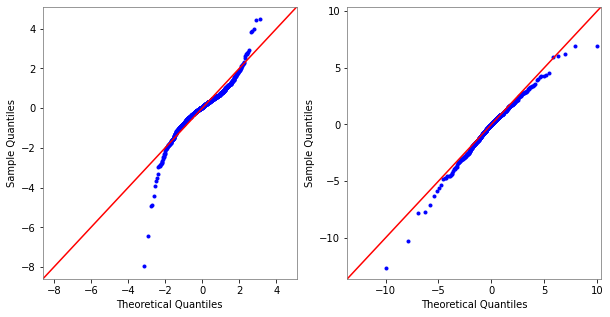

In [4]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,2,1)
sm.graphics.qqplot(df_ret, fit=True, line='45', ax = ax )
ax.get_lines()[0].set_markersize(3.0)
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_facecolor("white")

ax = fig.add_subplot(1,2,2)
sm.graphics.qqplot(df_ret, dist=t, distargs=(3), fit=True, line='45', ax = ax )
ax.get_lines()[0].set_markersize(3.0)
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_facecolor("white")

plt.savefig('qqplot_sp.png', dpi = 400, bbox_inches = 'tight')


The Q-Q plot of S\&P 500 index return (left) shows a downward deviation at the left and an upward deviation at the right, which conforms to the fat tail pattern. If we change the parametric curve into a line that follows the t-distribution with degree of freedom equals to 3 (right), more data points lie on the line, indicating the fat tail pattern of the S\&P 500 index return. ($\textbf{RQ3}$)

In [5]:
# sample 1000 points to plot the QQ plot
def sample(n_samples,priors, mus, sigmas, ncomps ):
    """
    this function generates samples from the GMM distribution with given parameters
    n_samples: number of samples needed to generate
    priors: gmm priors
    mus: gmm mu vector
    sigmas: gmm sigma vector
    ncomps: gmm number of additive components
    """
    probs = np.concatenate(([0], np.cumsum(priors)))
    np.random.seed(42)
    samples = np.zeros((n_samples, 1)) * np.nan
    i_sample = 0
    while np.isnan(samples[-1]).all():
        u = np.random.uniform()
        for i in range(ncomps):
            if probs[i] <= u < probs[i+1]:
                samples[i_sample] = multivariate_normal.rvs(mean=mus[i], cov=sigmas[i])
                i_sample += 1
                break
    return samples

In [6]:
for i in range(1,16,1):
    gmm_temp = GMM(ncomps = i, method = "kmeans")
    gmm_temp.fit(df_ret)

BIC for 1 components is -4980.1007944307
BIC for 2 components is -5218.744271485365
BIC for 3 components is -5229.826910735029
BIC for 4 components is -5220.531082828773
BIC for 5 components is -5213.4263198303615
BIC for 6 components is -5205.1278985081
BIC for 7 components is -5207.086323002375
BIC for 8 components is -5202.150371364573
BIC for 9 components is -5198.83800404066
BIC for 10 components is -5195.0033826818435
BIC for 11 components is -5195.015401792345
BIC for 12 components is -5189.96677919953
BIC for 13 components is -5184.888706995708
BIC for 14 components is -5185.679672732309
BIC for 15 components is -5195.199676865835


We used the BIC to select the optimal number of clusters and found that 3 is the optimal value. The following GMMs all have 3 components.

We've tried all three initialization methods. All of them perform similar fat tail results (see the following Q-Q plots), so we used kmeans here only.

In [7]:
gmm = GMM(ncomps = 3, method = "kmeans")
gmm.fit(df_ret)


BIC for 3 components is -5229.826910735029


Text(0.5, 1.0, 'density function')

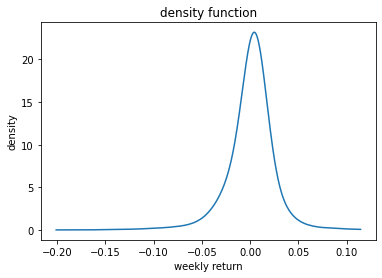

In [8]:
density = [gmm.pdf(ret) for ret in sorted(df_ret)]
plt.plot(sorted(df_ret), density)
plt.xlabel('weekly return')
plt.ylabel('density')
plt.title('density function')


The density plot of the S\&P 500 weekly return. Roughly seems to have fat tail. Further investigation needs to be conducted.

BIC for 1 components is -4980.100794430709


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 2 components is -5218.731561361245


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 3 components is -5229.790088293528


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 4 components is -5223.100380107826


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 1 components is -4980.100794430701


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 2 components is -5218.825180804016


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 3 components is -5216.72068487045


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 4 components is -5218.183004123541


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 1 components is -4980.100794430701


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 2 components is -5218.742149406721


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 3 components is -5229.82691073504


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


BIC for 4 components is -5220.531082828779


<ipython-input-9-f06f35f51efd>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=5)
<ipython-input-9-f06f35f51efd>:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=5)


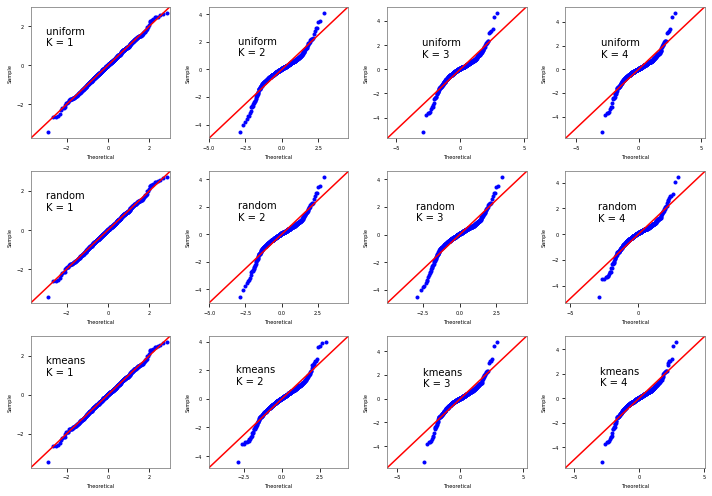

In [9]:
fig = plt.figure(figsize = (10,7))
for method_selected in ["uniform", "random", "kmeans"]:
    if method_selected == "uniform": 
        row = 0
    elif method_selected == "random":
        row = 1
    else:
        row = 2
        
    for i in range(1,5,1):
        gmm_temp = GMM(ncomps = i, method = method_selected)
        gmm_temp.fit(df_ret)
        
        ax = fig.add_subplot(3,4,i+row*4)
        
        sm.graphics.qqplot(sample(500,gmm_temp.priors_, gmm_temp.mus_, gmm_temp.sigmas_, gmm_temp.ncomps ).flatten(), 
                           fit=True, line='45', ax = ax )
        
        ax.get_lines()[0].set_markersize(3.0)
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color('0.5')
        ax.spines['right'].set_color('0.5')
        ax.spines['left'].set_color('0.5')
        ax.set_facecolor("white")
        
        plt.xlabel("Theoretical", size = 5)
        plt.ylabel("Sample", size = 5)
        plt.setp(ax.get_xticklabels(), Fontsize=5)
        plt.setp(ax.get_yticklabels(), Fontsize=5)
        txt_wrd = f'{method_selected}  \nK = {i}'
       
        ax.annotate(txt_wrd,
            xy=(-3, 1),size = 10)
        

fig.tight_layout()
plt.gcf()
plt.savefig('qqplot.png', dpi = 400, bbox_inches = 'tight')
        
        

Q-Q plots of GMM fitted S\&P with different initialization methods (Uniform Distribution Sampling, Random Sampling, K-means) and number of components (1$\sim$4). (horizontal: sample quantile, vertical: theoretical quantile). If we only used one component in the GMM model, the fitted distribution is also normal. When we used more than one components, the Q-Q plots all show similar fat tail pattern no matter what initialization methods we used.

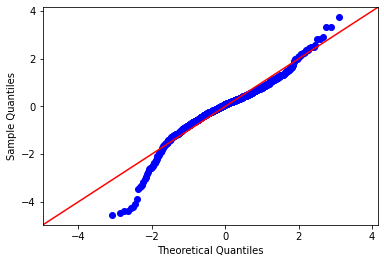

In [10]:
## qqplot
fig = sm.qqplot(sample(1000,gmm.priors_, gmm.mus_, gmm.sigmas_, gmm.ncomps ).flatten(), fit=True, line='45')

Both density plot and QQ plot indicate the obtained distribution is characterized by fat tails. 

## (iii) GMM's Failure in Fitting the Tail of the S&P Distribution

/Users/wendyshao/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/wendyshao/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


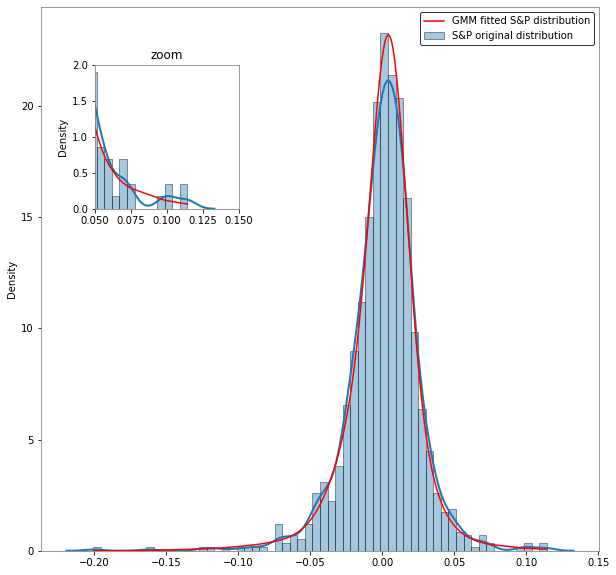

In [11]:
x = sorted(df_ret)
y = density

fig, ax = plt.subplots(figsize=(10,10))


sns.distplot(df_ret.values, hist=True, kde=True, 
             bins=int(180/3), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
            label='S&P original distribution',
                 ax = ax)

ax.plot(x, y, color = 'red', label = 'GMM fitted S&P distribution')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend(edgecolor = 'black').get_frame().set_facecolor('white')


ax2 = plt.axes([0.2, 0.6, .2, .2])
sns.distplot(df_ret.values, 
             bins=int(180/3), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=ax2, label='S&P original distribution')
ax2.plot(x, y, color = 'red', label = 'GMM fitted S&P distribution')
ax2.set_title('zoom')
ax2.set_xlim([.05,.15])
ax2.set_ylim([0,2])
ax2.spines['bottom'].set_color('0.5')
ax2.spines['top'].set_color('0.5')
ax2.spines['right'].set_color('0.5')
ax2.spines['left'].set_color('0.5')


plt.savefig('hist_GMM.png',dpi = 400, bbox_inches = 'tight',transparent=True  )


GMM fitted results and S\&P histogram with zoomed view on the tail distribution. In the zoomed view of the tail, we can see that the tail of the fitted GMM density is thinner than that of the kernel density. 

In [12]:
# Generate normal distribution samples with mean = sample_mean(weekly return), std = sample_std(weekly return)
# create quantile lists and corresponding sample value lists
mu = df_ret.mean()
sigma = df_ret.std()

s = np.random.normal(mu, sigma, 1000000)

y_normal = []
x_normal = []

for q in np.arange(0.8, 1, 0.001):
    y_normal.append(1-q)
    x_normal.append(pd.Series(s).quantile(q))

In [13]:
# Generate 1000 samples from estimated GMM
# create quantile lists and corresponding sample value lists
y_gmm = []
x_gmm = []
for q in np.arange(0.8, 1, 0.001):
    y_gmm.append(1-q)
    x_gmm.append(pd.Series(sample(1000,gmm.priors_, gmm.mus_, gmm.sigmas_, gmm.ncomps ).flatten()).quantile(q))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          1.146e+04
Date:                Sat, 20 Mar 2021   Prob (F-statistic):                   7.14e-178
Time:                        12:49:48   Log-Likelihood:                         -79.838
No. Observations:                 200   AIC:                                      161.7
Df Residuals:                     199   BIC:                                      165.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

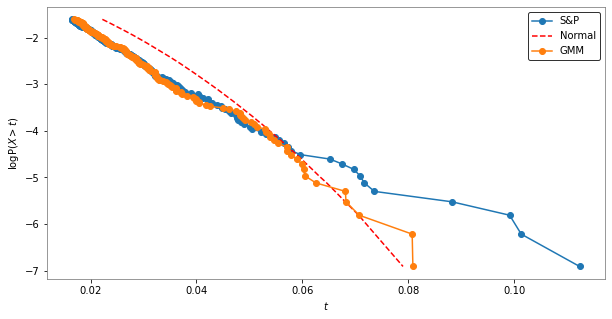

In [14]:
y = []
x = []

for q in np.arange(0.8, 1, 0.001):
    y.append(1-q)
    x.append(df_ret.quantile(q))


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, np.log(y), '-o', label = 'S&P')
ax.plot(x_normal, np.log(y_normal), '--r', label = 'Normal')
ax.plot(x_gmm, np.log(y_gmm),'-o', label = 'GMM')
ax.set_xlabel('$t$')
ax.set_ylabel('logP($X>t$)')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend(edgecolor = 'black').get_frame().set_facecolor('white')


import statsmodels.api as sm

model = sm.OLS(np.log(y), x)
res = model.fit()
plt.savefig('log_plot_tail.png', dpi = 400, bbox_inches = 'tight', transparent= 'True')
print(res.summary())

Log plot of the tail. When the weekly return is small and near the center of the distribution, the GMM distribution fits the true data much better than normal distribution. When the weekly return is large and at the tail of the distribution, it approaches normal distribution in an asymptotic manner.\
To verify GMM's failure in reproducing the tails of S\&P, we quantitatively deduced the downward trend of S\&P original data by fitting a linear model with no intercept. The $R^2$ of the fitted model is over 98$\%$, indicating the S\&P original data declines at a rate of $\exp(-at), a>0$, which is slower than the declining rate of GMM and normal distribution. (see below proof)

To address $\textbf{RQ4}$, we need to quantify the tail distribution of GMM. The bound of the GMM tail distribution is very similar to the Gaussian distribution. The tail of the Gaussian distribution can be bounded by the following inequality:
\begin{equation}
    \frac{\mathrm{e}^{-\frac{t^2}{2}}}{\sqrt{2\pi}}\left(\frac{1}{t} - \frac{1}{t^3} \right) \leq P(X > \mu +\sigma t) \leq \frac{\mathrm{e}^{\frac{-t^2}{2}}}{t \sqrt{2\pi}}\label{con:bound}
\end{equation}
    where $ t>0 $ .
    
For the GMM distribution:
    \begin{equation}
    \begin{aligned}
    p(x) &= \sum_{k = 1}^K \alpha_k N(x | \mu_k, \sigma_k)\\
    &= \sum_{k = 1}^K \alpha_k \frac{1}{\sqrt{2\pi}\sigma_k}\exp\left(-\frac{(x - \mu_k)^2}{2\sigma_k^2} \right)\\
   &= \sum_{k=1}^K \alpha_k p_k(x)
   \end{aligned}
   \end{equation}
   which naturally leads to the tail distribution:
  \begin{equation}
    \begin{aligned}
   P(X>t) = \sum_{k=1}^K \alpha_k P_k(x > t)
   \end{aligned}
   \end{equation}
    
The tail distribution $P_k(x > \mu_k + \sigma_k t)$ can be bounded by the first inequality. Thus, the tail distribution of $p(x)$, $P(X>t)$ is within the region restricted by the following boundary:
    \begin{equation}
    \begin{aligned}
     &\sum_{k=1}^K \frac{\alpha_k\sigma_k}{\sqrt{2\pi}}\left(\frac{1}{(t - \mu_k)} - \frac{1}{(t - \mu_k)^3}\right)\exp{\frac{-(t-\mu_k)^2}{2\sigma_k^2}}\\  
     \le & P(X>t)\\
     \le & \sum_{k=1}^K \frac{\alpha_k\sigma_k}{\sqrt{2\pi}(t - \mu_k)}\exp{\frac{-(t-\mu_k)^2}{2\sigma_k^2}}
    \end{aligned}
    \end{equation}
    as we can see if $t\to\infty$, we have
    
  \begin{equation}
        P(X>t) = \Omega\left(\frac{\alpha_{k\max}\sigma_{k\max}}{\sqrt{2\pi}(t - \mu_{k\max})}\exp{\frac{-(t-\mu_{k\max})^2}{2\sigma_{k\max}}}\right)
    \end{equation}
 
  so the asymptotic tail probability of GMM has the same order of magnitude as the Gaussian distribution.

All of this evidence shows that GMM can capture a part of tail risk near the tail part but fail to reproduce correctly the fat tail of S\&P index returns. ($\textbf{RQ4}$) 